In [1]:
import os
import copy
import matplotlib.pyplot as plt
from itertools import product

from torch import optim

from utils import *

In [2]:
OPTIMIZER = optim.NAdam
TARGET_DIR = "results/NAdam"
os.makedirs(TARGET_DIR, exist_ok = True)

# 探索するパラメータと探索空間
SEARCH_SPACE = {
    "lr": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "weight_decay": [0.1, 0.01, 0.001, 0.0001, 0.0],
}
# 固定のパラメータ
FIXED_PARAMS ={
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "momentum_decay": 0.004,
    "decoupled_weight_decay": False
}

EPOCHS, BATCH_SIZE, TEST_SIZE, NUM_WORKERS, NUM_SEED

(100, 16, 0.1, 1, 10)

In [3]:
train_dataloader, test_dataloader = load_data(batch_size = BATCH_SIZE,
                                              seed = 0,
                                              test_size = TEST_SIZE,
                                              num_workers = NUM_WORKERS)
inputs, teacher_signals = next(iter(train_dataloader))
inputs.shape, teacher_signals.shape, inputs[0]

(torch.Size([16, 4]),
 torch.Size([16]),
 tensor([5.5000, 3.5000, 1.3000, 0.2000]))

In [4]:
model = load_model(seed = 0)
model( torch.zeros(size = (1, 4)) )

tensor([[-0.4777, -0.3311, -0.2061]], grad_fn=<AddmmBackward0>)

In [ ]:
for PARAMS in product(*SEARCH_SPACE.values()):

    # 探索空間のパラメータ
    params = {
        K: P for K, P in zip(SEARCH_SPACE.keys(), PARAMS)
    }
    
    for seed in range(NUM_SEED):
        
        tmp = ""
        for V in params.values():
            tmp += f"{V}_"
        tmp = tmp[:-1]
        target_path = f"{TARGET_DIR}/{tmp}_{seed}.json"

        if os.path.exists(target_path):
            continue

        # 最適化手法のパラメータ
        optimizer_params = {
            **params,
            **FIXED_PARAMS
        }
        
        print(target_path)
        train(target_path = target_path,
              optimizer = OPTIMIZER,
              optimizer_params = optimizer_params,
              scheduler = None,
              seed = seed
            )

results/NAdam/1.0_0.1_0.json
results/NAdam/1.0_0.1_1.json


In [ ]:
# 全seedの中でベストの結果を抽出
best_histories = dict()
for PARAMS in product(*SEARCH_SPACE.values()):

    # 探索空間のパラメータ
    params = {
        K: P for K, P in zip(SEARCH_SPACE.keys(), PARAMS)
    }

    max_test_acc = 0
    for seed in range(NUM_SEED):
        tmp = ""
        for V in params.values():
            tmp += f"{V}_"
        tmp = tmp[:-1]
        target_path = f"{TARGET_DIR}/{tmp}_{seed}.json"
        logger = ResultLogger(target_path = target_path)

        max_test_acc = max(max_test_acc, logger["test_acc"][-1])
        if max_test_acc == logger["test_acc"][-1]:
            best_histories[tmp] = logger

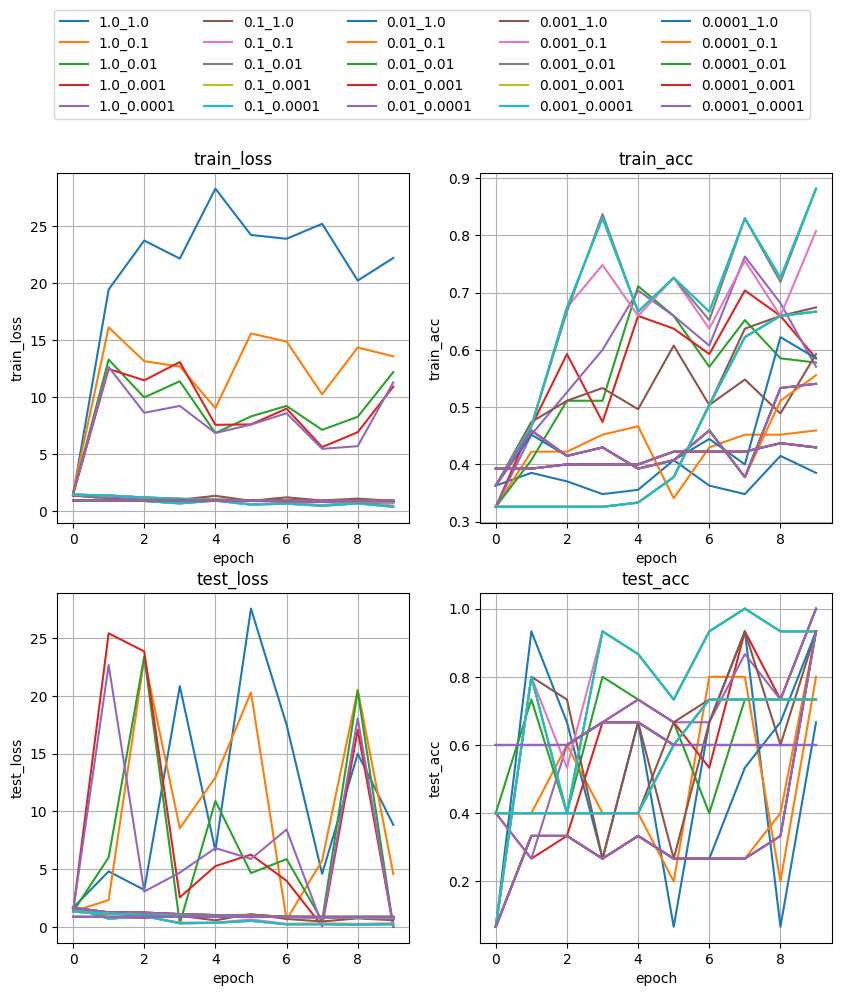

In [ ]:
fig = plt.figure(figsize = (10, 10))
for i, M in enumerate(METRICS):
    # TODO
    ax = fig.add_subplot(2, 2, i + 1)
    for K, V in best_histories.items():
        ax.plot(V[M], label = f"{K}")
    ax.set_xlabel("epoch")
    ax.set_ylabel(M)
    ax.set_title(M)
    ax.grid()

tmp = ""
for K in SEARCH_SPACE.keys():
    tmp += f"{K}_"
tmp = tmp[:-1]
fig.suptitle(tmp)

fig.legend(
    labels=[K for K in best_histories.keys()],
    loc='upper center',
    ncol=5,  # 横に並べる列数
    bbox_to_anchor=(0.5, 1.05) # figure の外に配置
)

fig.savefig(f"{TARGET_DIR}/training_result.png", bbox_inches = "tight")

In [ ]:
tmp = [
    [K, V["test_acc"][-1]] for K, V in best_histories.items()
]
tmp = sorted(tmp, key=lambda x: x[1], reverse=True)
for K, V in tmp:
    print(f"{K}: {V:.4f}")

1.0_0.01: 1.0000
1.0_0.001: 1.0000
1.0_0.0001: 1.0000
0.1_1.0: 0.9333
0.1_0.1: 0.9333
0.1_0.01: 0.9333
0.1_0.001: 0.9333
0.1_0.0001: 0.9333
0.01_1.0: 0.9333
0.01_0.1: 0.9333
0.01_0.01: 0.9333
0.01_0.001: 0.9333
0.01_0.0001: 0.9333
1.0_0.1: 0.8000
0.001_1.0: 0.7333
0.001_0.1: 0.7333
0.001_0.01: 0.7333
0.001_0.001: 0.7333
0.001_0.0001: 0.7333
1.0_1.0: 0.6667
0.0001_1.0: 0.6000
0.0001_0.1: 0.6000
0.0001_0.01: 0.6000
0.0001_0.001: 0.6000
0.0001_0.0001: 0.6000
